In [1]:
import time
import socket
import random
import threading
import matplotlib.pyplot as plt

In [2]:
class RPL(threading.Thread):
    
    transfer_loss = {"send":0.005,"receive":0.002}
    transfer_threshold = {"send": 1.5, "receive": 0.5}
    metric = {'dist':-1,'rank': -0.50,'power':0.50}
    ATTEMPT_TIME = 1
    MAX_ATTEMPT = 10
    INF = 999

    def __init__(self,addr,coor):
        super(RPL,self).__init__()
        self.addr = addr
        self.coor = coor #[x,y]
        self.node_id = "%s:%s"%addr
        self.dis_id = 0
        self.power = 5
        self.rank = None
        self.dist = None
        self.sent_bytes = 0
        self.received_bytes = 0
        self.dis_id_list = {}
        self.sent_dis = {}
        self.recv_dio = {}
        self.parents = {}
        self.childs = {}
        self.best_parent = {} #{'node_id':node_id,'score':score}
        self.msg_box = {}
        self.pending_msg_q = {}
        self.sock = socket.socket()
        self.sock.bind(addr)
        self.sock.listen(5)

    def connect(self,nodes):
        if not isinstance(nodes,list):
            nodes = [nodes]
        for node in nodes:
            s = socket.socket()
            s.connect(node)
            s.send(self.node_id.encode())
            self.parents['%s:%s'%node] = s
            threading.Thread(target=self.listener,args=(s,)).start()

    def max_byte(self,operation):
        avail_pow = self.power-self.transfer_threshold[operation]
        byte = avail_pow/self.transfer_loss[operation]
        return int(byte)

    def power_loss(self,message,op):
        loss = len(message)*self.transfer_loss[op]
        return loss

    def readline(self,sock):
        try:
            data = sock.recv(1)
            while b'\r\n' not in data:
                data += sock.recv(1)
            return data.decode()
        except:
            return ''

    def listener(self,sock):
        while True:
            message = self.readline(sock)
            if message:
                if message[:4] == 'USER':
                    if len(message)<=self.max_byte('receive'):
                        print('Received %s bytes'%len(message))
                        # Update params
                        self.received_bytes += len(message)
                        self.power -= self.power_loss(message,'receive')
                        self.on_recv(message)
                    else:
                        print('Low power')
                else:
                    self.on_recv(message)

    def on_recv(self,message):
        message = message.split('|')
        # Process message
        switch = {'DIS':self.process_dis,
                  'DIO':self.process_dio,
                  'USER': self.process_msg}
        switch[message[0]](message)

    def send(self,sock,message):
        if message[:4] != 'USER':
            # send message
            sock.send(message.encode())
        else:
            if len(message)<=self.max_byte('send'):
                # send message
                sock.send(message.encode())
                # Update params
                self.sent_bytes += len(message)
                self.power -= self.power_loss(message,'send')
                print('Sent %s bytes'%len(message))
            else:
                print('Low power',self.power)

    def distance(self,coor):
        dx = float(coor[0])-self.coor[0]
        dy = float(coor[1])-self.coor[1]
        return (dx**2+dy**2)**0.5

    def send_dis(self,dest):
        self.dis_id += 1
        message = 'DIS|%s|%s|%s|\r\n'%(self.dis_id,self.node_id,dest)
        self.sent_dis[dest] = set()
        self.recv_dio[dest] = set()
        for parent in self.parents:
            self.send(self.parents[parent],message)
            self.sent_dis[dest].add(parent)

    def process_dis(self,message):
        dis_id = message[1]
        orig = message[2]
        dest = message[3]
        if self.node_id == orig:
            return
        if orig in self.dis_id_list:
            # Discard duplicate dis mesage
            if self.dis_id_list[orig] == dis_id:
                return
        # Buffer dis id
        self.dis_id_list[orig] = dis_id

        if self.node_id == dest:
            # send dio
            self.send_dio()
        elif self.parents:
            self.forward_dis(message)
        else:
            # send dio with infinite distance and rank from sink
            self.send_dio(self.INF,self.INF)

    def forward_dis(self,message):
        message = '|'.join(message)
        for parent in self.parents:
            self.send(self.parents[parent],message)

    def send_dio(self,orig=None,rank=0,dist=0,power=None):
        self.rank = rank # rank from sink
        self.dist = dist # distance from sink
        orig = orig or self.node_id
        power = power or self.INF
        message = 'DIO|%s|%s|%s,%s|%s|%s|%s|\r\n'%(orig,self.node_id,*self.coor,self.rank,self.dist,power)
        for node in self.childs:
            self.send(self.childs[node],message)

    def process_dio(self,message):
        # return if current node is sink
        if self.rank==0:return
        orig = message[1]
        sender = message[2]
        coor = message[3].split(',')
        rank = int(message[4])+1
        dist = float(message[5])+self.distance(coor)
        power = min(float(message[6]),self.power)

        if orig in self.recv_dio:
            self.recv_dio[orig].add(sender)

        score = self.obj_func({'dist':dist,'power':power,'rank':rank})

        if not self.best_parent:
            self.best_parent['node_id'] = sender
            self.best_parent['score'] = score
        elif self.best_parent['score'] < score:
            # Update best parent
            self.best_parent['node_id'] = sender
            self.best_parent['score'] = score
        else:
            return
        # Send DIO if best parent updated
        self.send_dio(orig,rank,dist,power)

    def obj_func(self,dictionary):
        score = 0
        for key in dictionary:
            if key in self.metric:
                score += dictionary[key]*self.metric[key]
            else:
                score += dictionary[key]
        return score

    def send_msg(self,dest,msg_data):
        message = 'USER|%s|%s|%s|\r\n'%(self.node_id,dest,msg_data)
        self.send_dis(dest)
        for _ in range(self.MAX_ATTEMPT):
            if len(self.sent_dis[dest]) == len(self.recv_dio[dest]):
                if self.best_parent:
                    best_parent = self.best_parent['node_id']
                    self.send(self.parents[best_parent],message)
                    # send pending msg if available
                    if self.pending_msg_q:
                        self.send_pending_msgs()
                    return
                else:
                    break
            else:
                time.sleep(self.ATTEMPT_TIME)
        self.pending_msg_q[dest] = {'orig':self.node_id,'msg_data':msg_data}

    def send_pending_msgs(self):
        if self.best_parent:
            for dest in list(self.pending_msg_q):
                msg = self.pending_msg_q.pop(dest)
                orig = msg['orig']
                msg_data = msg['msg_data']
                message = 'USER|%s|%s|%s|\r\n'%(orig,dest,msg_data)
                best_parent = self.best_parent['node_id']
                self.send(self.parents[best_parent],message)

    def process_msg(self,message):
        orig = message[1]
        dest = message[2]
        msg_data = message[3]
        if self.node_id == dest:
            self.msg_box[orig] = msg_data
            print('New message arrived')
        else:
            self.forward_msg(message)

    def forward_msg(self,message):
        orig = message[1]
        dest = message[2]
        msg_data = message[3]
        message = '|'.join(message)

        if self.best_parent:
            best_parent = self.best_parent['node_id']
            self.send(self.parents[best_parent],message)
        else:
            self.pending_msg_q[dest] = {'orig':orig,'msg_data':msg_data}

    def run(self):
        while True:
            try:
                conn , _ = self.sock.accept()
                self.childs[conn.recv(21).decode()] = conn
                threading.Thread(target=self.listener,args=(conn,)).start()
            except:
                print('Connection closed\n')
                break

In [3]:
class Node(RPL):
    def __init__(self,addr,dist_range=[1,50]):
        coor = [random.randint(*dist_range), random.randint(*dist_range)]
        super(Node,self).__init__(addr,coor)

In [4]:
class Network:
    ATTEMPT_TIME = 0.5
    MAX_ATTEMPT = 10

    def __init__(self,no_of_node,ip='127.0.0.1',start_port=8010):
        self.no_of_node = no_of_node
        self.nodes = {}
        for i in range(no_of_node):
            addr = (ip,start_port+i)
            self.nodes['%s:%s'%addr] = Node(addr)
            self.nodes['%s:%s'%addr].start()
        # Initilize neighbour
        self.init_neighbour()

    def init_neighbour(self):
        for node in self.nodes:
            self.nodes[node].best_parent = {}
            self.nodes[node].parents = {}
            self.nodes[node].childs = {}
        for node1 in self.nodes:
            for node2 in self.nodes:
                if self.nodes[node1].distance(self.nodes[node2].coor) <= self.nodes[node1].power**2 and node1 != node2:
                    self.nodes[node2].connect(self.nodes[node1].addr)

    def shutdown(self):
        for node in self.nodes.values():
            node.sock.close()
            for parent in node.parents.values():
                parent.close()

    def reset(self,factor):
        for node in self.nodes:
            self.nodes[node].metric = {'dist':-1,'rank': -1+factor,'power':factor}
            self.nodes[node].power = 5
            self.nodes[node].rank = None
            self.nodes[node].dist = None
            self.nodes[node].sent_bytes = 0
            self.nodes[node].received_bytes = 0
            self.nodes[node].best_parent = {}
            self.nodes[node].msg_box = {}
            self.nodes[node].pending_msg_q = {}

    def plot_transfer_stat(self,dest):
        transfer = []
        power = []
        for i in [0.0,0.2,0.4,0.6,0.8,1.0]:
            total = 0
            self.reset(i)               
            self.start_season(dest)
            for name,node in self.nodes.items():
                total += node.received_bytes+node.sent_bytes
            transfer.append(total/self.no_of_node)
            power.append(i)
        plt.plot(power,transfer)
        plt.show()
  
    def plot_neighbour_connection(self):
        for node in self.nodes:
            for child in self.nodes[node].childs:
                x = [self.nodes[node].coor[0],self.nodes[child].coor[0]]
                y = [self.nodes[node].coor[1],self.nodes[child].coor[1]]
                plt.plot(x, y, '-o')

    def plot_best_parent_connection(self):
        for node in self.nodes.values():
            if node.best_parent:
                best_parent = self.nodes[node.best_parent['node_id']]
                x = [best_parent.coor[0],node.coor[0]]
                y = [best_parent.coor[1],node.coor[1]]
                plt.plot(x, y, '-o')

    def plot_network(self):
        x=[]
        y=[]
        c=[]
        s=[]
        plt.figure(figsize=(30,15),dpi=200)
        for node in self.nodes.values():
            x.append(node.coor[0])
            y.append(node.coor[1])
            c.append(node.power)
            s.append(3.14*25**2) # mult 8.1
            plt.text(x[-1], y[-1],node.node_id,size=20,horizontalalignment='center',verticalalignment='center',bbox=dict(facecolor='red', alpha=0.4))
        plt.scatter(x, y, s=s, c=c, alpha=0.6,picker=True)
        plt.grid(True)

    def start_season(self,dest):
        for node in self.nodes:
            if node != dest:
                self.init_neighbour()
                self.nodes[node].send_msg(dest,'PING')
                # Check whether msg reaches to dest
                for _ in range(self.MAX_ATTEMPT):
                    if node in self.nodes[dest].msg_box:
                        break
                    time.sleep(self.ATTEMPT_TIME)

In [5]:
try:network.shutdown()
except:pass
network = Network(10)

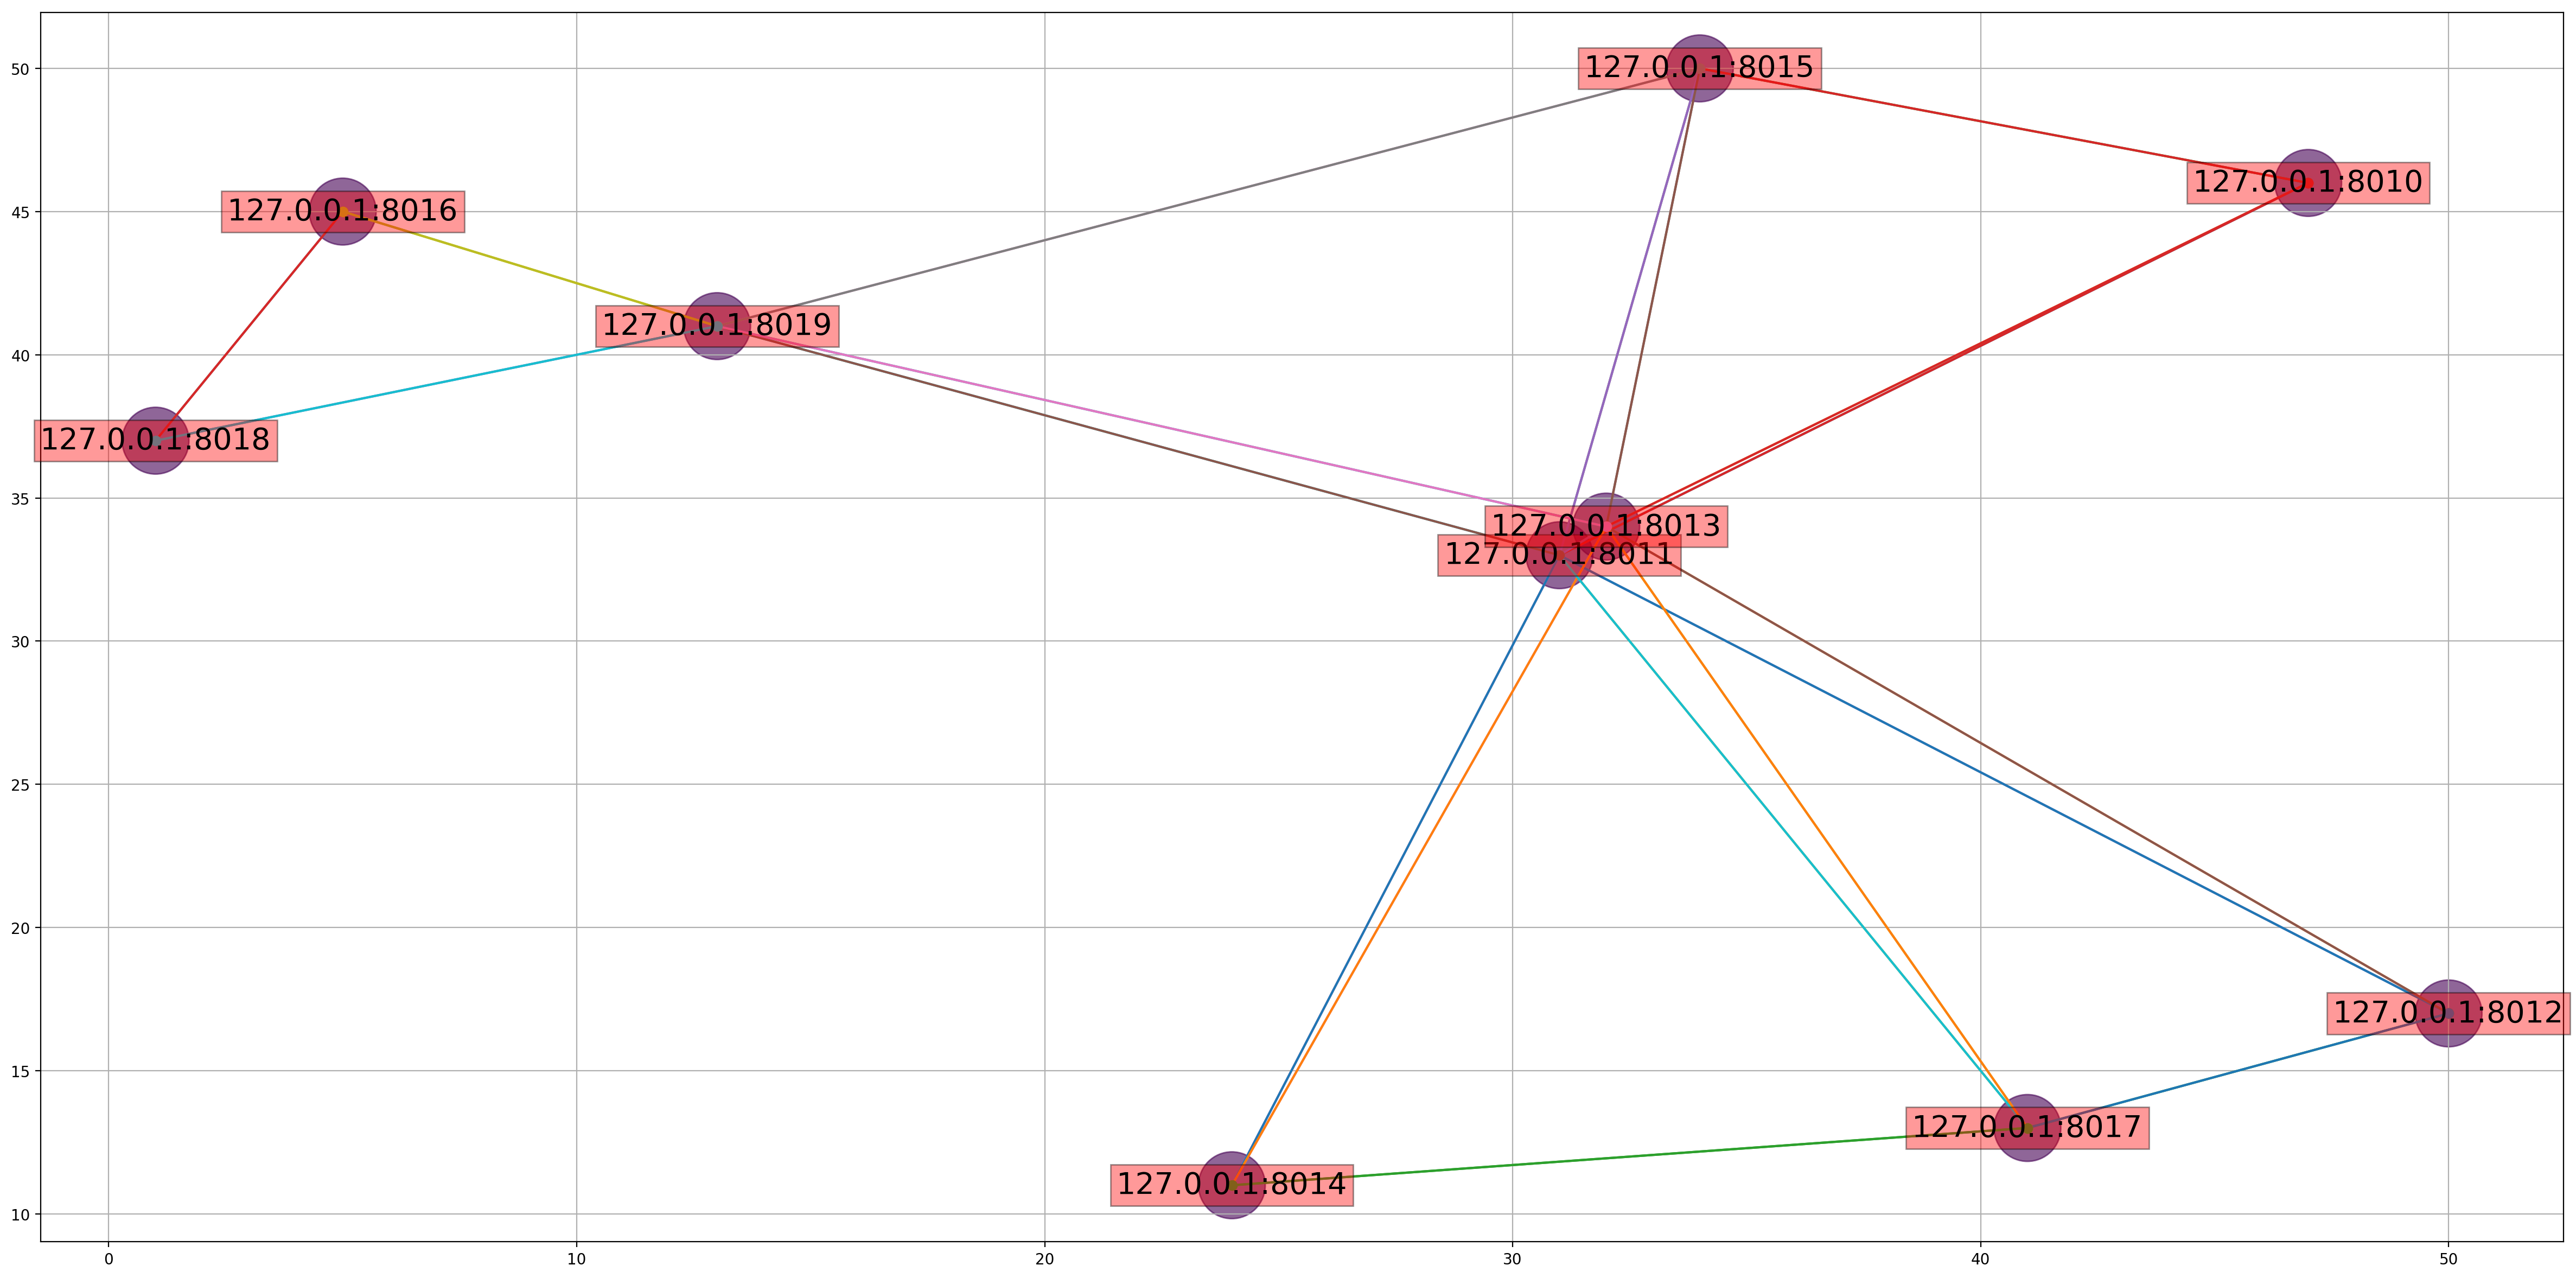

In [6]:
network.plot_network()
network.plot_neighbour_connection()

In [7]:
network.nodes['127.0.0.1:8019'].send_dio()

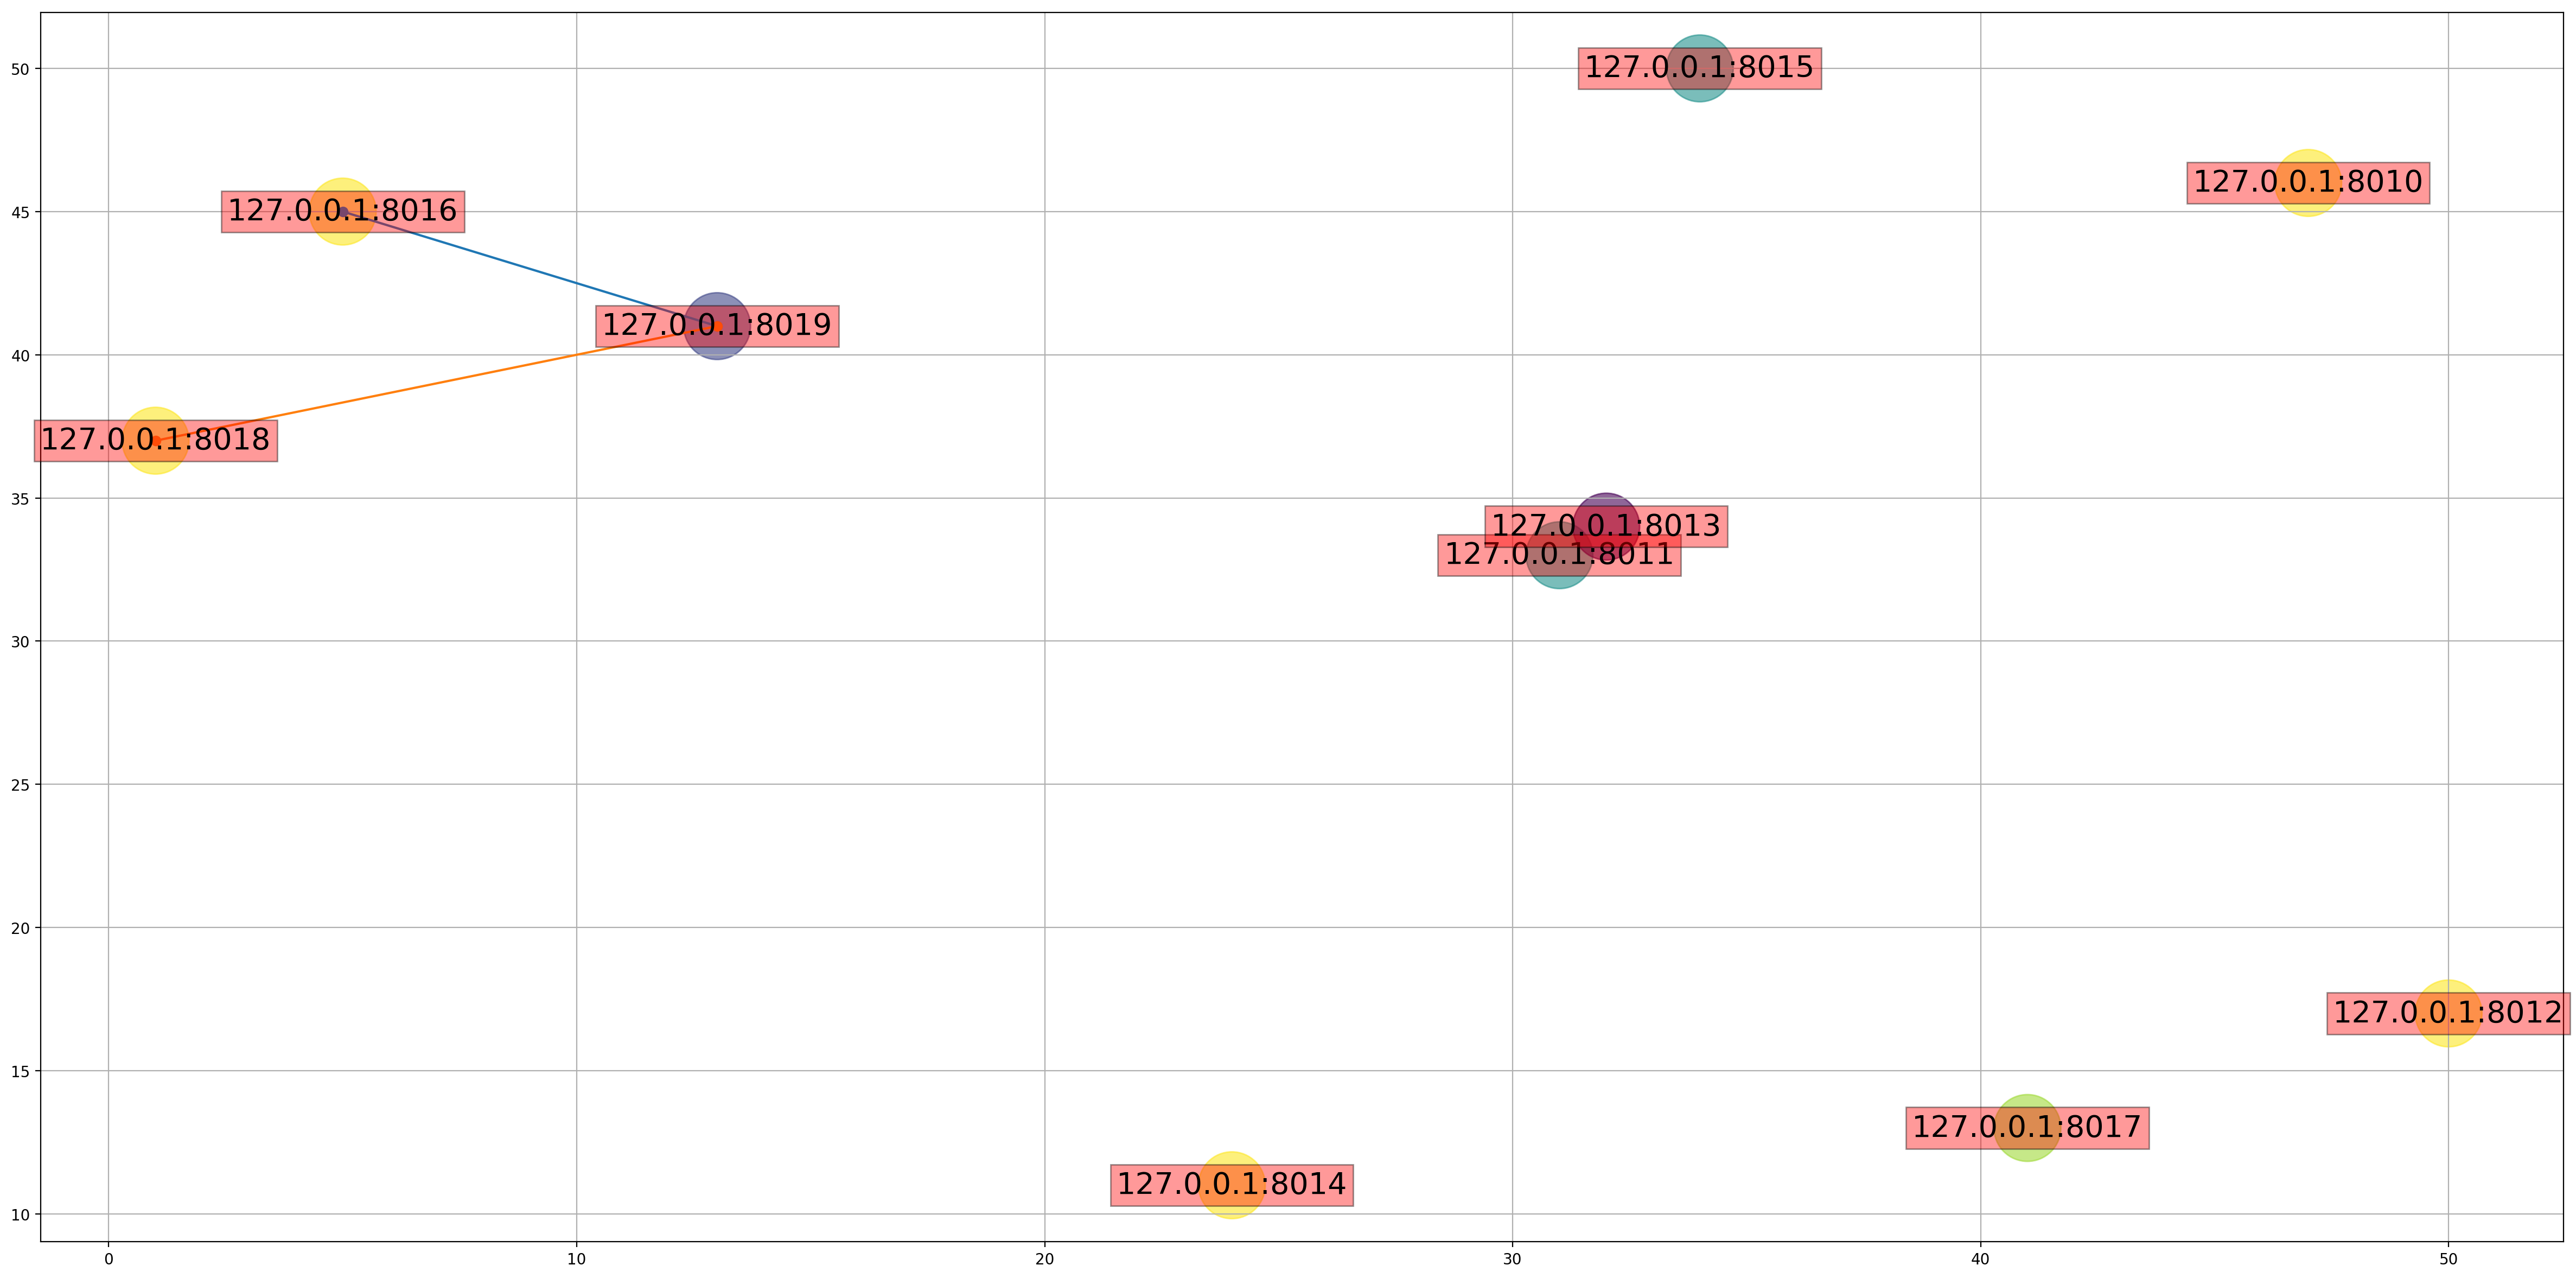

In [13]:
network.plot_network()
network.plot_best_parent_connection()

Sent 42 bytesReceived 42 bytes

Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytesReceived 42 bytes

Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytesReceived 42 bytes

Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytesReceived 42 bytes
New message arrived

Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytesReceived 42 bytes

Sent 42 bytes
Received 42 bytes
New message arrived
Received 42 bytesSent 42 bytes

New message arrived
Sent 42 bytesReceived 42 bytes

Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent

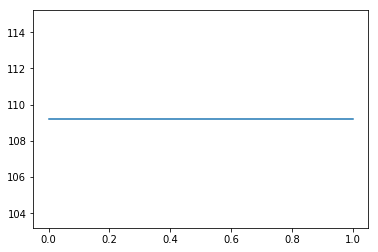

In [9]:
network.plot_transfer_stat('127.0.0.1:8019')

In [12]:
network.nodes['127.0.0.1:8019'].msg_box

{'127.0.0.1:8010': 'PING',
 '127.0.0.1:8011': 'PING',
 '127.0.0.1:8012': 'PING',
 '127.0.0.1:8013': 'PING',
 '127.0.0.1:8014': 'PING',
 '127.0.0.1:8015': 'PING',
 '127.0.0.1:8016': 'PING',
 '127.0.0.1:8018': 'PING'}

Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytesReceived 42 bytes
New message arrived

Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
Sent 42 bytes
Received 42 bytes
New message arrived
Sent 42 bytes
Received 42 bytes
Sent

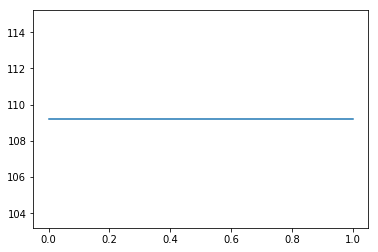

In [10]:
network.plot_transfer_stat('127.0.0.1:8019')